In [1]:
import matplotlib.pyplot as plt
from catboost import CatBoostRanker, Pool
from kaggle_hm.chart_model import filter_data
from copy import deepcopy
import numpy as np
import os
import seaborn as sns
import pandas as pd
from kaggle_hm.config import data_root, train_dates, test_dates
from kaggle_hm.evaluation import compute_precision
import kaggle_hm.als_model
from kaggle_hm.chart_model import age_chart
from kaggle_hm.evaluation import plot_precision_at_k, enrich_data, precision_by_age, precision_by_usage
from kaggle_hm import ranking_features as rf
from sklearn.model_selection import train_test_split
from importlib import reload

In [2]:
rf = reload(kaggle_hm.ranking_features)

In [3]:
c = pd.read_parquet(data_root / 'clean' / 'customers.parquet')
c['age'] = c['age'].fillna(c['age'].mean())
c['age_group'] = pd.cut(c['age'], bins=[15, 21, 25, 30, 40, 50, 60, 100])
items = pd.read_parquet(data_root / 'clean' / 'articles.parquet')

df = pd.read_parquet(data_root / 'clean' / 'transactions.parquet')
df = df.merge(c[['customer_id', 'age', 'age_group']], on='customer_id')
df['product_code'] = df['article_id'].str[1:7].astype('int')

df = df.merge(items[['article_id', 'product_type_name', 'colour_group_name', 'department_name']], on='article_id')

cols = [f'rel_{i + 1}' for i in range(12)]

In [29]:
features = [
    'score',
    'article_totals',
    'age',
    'product_type_name_preference_clean',
    'colour_group_name_preference_clean',
    'department_name_preference_clean',
    'total_cust',
    'item_age',
    'monday_item',
    'avg_per_customer',
    'daily_sales',
    'avg_price',
    'avg_age',
    'product_totals',
    'segment',
    'method'
]

In [5]:
delta = (pd.to_datetime('2020-09-08') - df['t_dat']).dt.days
df['delta_weeks'] = 1 / (1 + np.power(delta // 7, 1))

train = filter_data(df, from_date='2020-09-01', to_date=train_dates['end'])

test = filter_data(df, from_date=test_dates['start'], to_date=test_dates['end'])
results = test.groupby('customer_id', observed=True).agg(bought=('article_id', set)).reset_index()
full_ds = filter_data(df, to_date=train_dates['end'])

t_cust = set(train['customer_id'].unique())
old_cust = set(full_ds['customer_id'].unique()) - t_cust
cold_cust = set(test['customer_id'].unique()) - old_cust - t_cust

In [6]:
candidates = pd.read_parquet(data_root / 'clean' / 'candidates.parquet').drop(columns=['price', 'item_id'])
candidates['method'] = 'als'

In [7]:
semantic_candidates = pd.read_parquet(data_root / 'clean' / 'semantic_candidates.parquet')
semantic_candidates = semantic_candidates[semantic_candidates['customer_id'].isin(test['customer_id'].unique())].copy()
semantic_candidates['method'] = 'tfidf'

In [8]:
rules_candidates = pd.read_parquet(data_root / 'clean' / 'association_rules.parquet')
rules_candidates = rules_candidates[rules_candidates['customer_id'].isin(test['customer_id'].unique())].copy()
rules_candidates['method'] = 'rules'

In [9]:
combined_candidates = pd.concat([candidates,
                                 semantic_candidates[['score', 'customer_id', 'article_id', 'is_relevant', 'method']],
                                 rules_candidates[['score', 'customer_id', 'article_id', 'is_relevant', 'method']]
])

In [10]:
print(candidates.shape, semantic_candidates.shape, rules_candidates.shape, combined_candidates.shape)

(6535300, 5) (3853536, 5) (447712, 5) (10836548, 5)


In [11]:
combined_candidates = combined_candidates.drop_duplicates(subset=['customer_id', 'article_id'], keep='first') # try last

In [12]:
combined_candidates['is_relevant'].sum(), combined_candidates['customer_id'].nunique()

(29254, 65353)

In [13]:
rel_stats = combined_candidates.groupby('customer_id').agg(relevant=('is_relevant', 'sum'))
rel_stats['relevant'].value_counts().sort_index()

0     45834
1     13455
2      3943
3      1298
4       476
5       169
6        92
7        37
8        22
9         6
10       12
11        3
12        3
13        2
14        1
Name: relevant, dtype: int64

In [14]:
combined_candidates.head()

,score,customer_id,article_id,is_relevant,method
0,0.046631,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0685813001,0,als
72,0.011759,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0917606004,0,als
71,0.011767,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0919741001,0,als
70,0.011869,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0685816001,0,als
69,0.011914,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0791837002,0,als


In [15]:
candidates = combined_candidates.sort_values('customer_id').copy()

In [16]:
candidates['product_code'] = candidates['article_id'].str[1:7].astype('int')
candidates['score_rank'] = candidates.groupby('customer_id')['score'].rank(ascending=False, method='first')

last_transactions = filter_data(df, from_date='2020-08-01', to_date='2020-09-08') # isin test customers
candidates = rf.calc_features(candidates, last_transactions, c, items)

old_transactions = filter_data(df, from_date='2020-08-01', to_date='2020-09-08')
item_stats = rf.get_item_stats(old_transactions, '2020-09-08')
candidates = candidates.merge(item_stats, on='article_id', how='left')

candidates['segment'] = 'old'
candidates.loc[candidates['customer_id'].isin(t_cust), 'segment'] = 'train'
candidates.head()

,score,customer_id,article_id,is_relevant,method,product_code,score_rank,article_totals,product_totals,age,...,garment_group_name,total_cust,uniq_customers,avg_price,avg_age,item_age,daily_sales,monday_item,avg_per_customer,segment
0,0.046631,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0685813001,0,als,685813,1.0,NaN,NaN,24.0,...,Jersey Basic,870.0,671.0,0.016580,33.388246,0.025641,22.307692,0.0,1.296572,old
1,0.043729,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0685813039,0,als,685813,2.0,NaN,NaN,24.0,...,Jersey Basic,249.0,232.0,0.016469,35.843373,0.034483,8.892857,0.0,1.073276,old
2,0.043092,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0685813018,0,als,685813,3.0,NaN,NaN,24.0,...,Jersey Basic,323.0,284.0,0.016509,38.832817,0.025641,8.500000,0.0,1.137324,old
3,0.040875,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0685813037,0,als,685813,4.0,NaN,NaN,24.0,...,Jersey Basic,555.0,466.0,0.016564,31.707004,0.025641,14.230769,0.0,1.190987,old
4,0.037867,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0685813043,0,als,685813,5.0,NaN,NaN,24.0,...,Jersey Basic,316.0,279.0,0.016564,34.032870,0.043478,13.739130,1.0,1.132616,old


In [17]:
cond = (
    (df['t_dat'] <= '2020-09-08')
)

customer_totals = df[cond].groupby('customer_id', observed=True, as_index=False).agg(total_items=('article_id', 'count'))

In [18]:
prod_type_stats = rf.cat_feature_prop(df[cond], 'product_type_name')
candidates = candidates.merge(prod_type_stats, on=['customer_id', 'product_type_name'], how='left')

colour_group_stats = rf.cat_feature_prop(df[cond], 'colour_group_name')
candidates = candidates.merge(colour_group_stats, on=['customer_id', 'colour_group_name'], how='left')

department_stats = rf.cat_feature_prop(df[cond], 'department_name')
candidates = candidates.merge(department_stats, on=['customer_id', 'department_name'], how='left')

# prod_type_stats = rf.cat_feature_prop(df[cond], 'section_name')
# train = train.merge(prod_type_stats, on=['customer_id', 'section_name'], how='left')

In [21]:
candidates = candidates.merge(customer_totals, on='customer_id', how='left')

In [27]:
candidates['colour_group_name_preference_clean'] = candidates['colour_group_name_preference'].combine_first(2/(7+candidates['total_items']))
candidates['product_type_name_preference_clean'] = candidates['product_type_name_preference'].combine_first(2/(7+candidates['total_items']))
candidates['department_name_preference_clean'] = candidates['department_name_preference'].combine_first(2/(7+candidates['total_items']))

In [30]:
train_customers, test_customers = train_test_split(test['customer_id'].unique(), test_size=0.2, random_state=42)

train_df = candidates[candidates['customer_id'].isin(train_customers)].copy()
test_df = candidates[candidates['customer_id'].isin(test_customers)].copy()

X_train = train_df[features]
y_train = train_df['is_relevant']
queries_train = train_df['customer_id']

X_test = test_df[features]
y_test = test_df['is_relevant']
queries_test = test_df['customer_id']

train_pool = Pool(
    data=X_train,
    label=y_train,
    group_id=queries_train,
    cat_features=['segment', 'method']
)

test_pool = Pool(
    data=X_test,
    label=y_test,
    group_id=queries_test,
    cat_features=['segment', 'method']
)

In [31]:
candidates[candidates['customer_id'].isin(train_customers)]['customer_id'].nunique() / len(train_customers)

0.9070901674911047

In [25]:
candidates[candidates['customer_id'].isin(test_customers)]['customer_id'].nunique() / len(test_customers)

0.9088447653429603

In [36]:
default_parameters = {
    'iterations': 2000,
    'custom_metric': ['MAP:top=10', 'NDCG'],
    'verbose': True,
    'metric_period': 200,
    'task_type': 'GPU',
    'devices': '0',
    'random_seed': 0,
    'learning_rate': 0.01,
    'one_hot_max_size': 10
}

parameters = {}

def fit_model(loss_function, additional_params=None, train_pool=train_pool, test_pool=test_pool):
    parameters = deepcopy(default_parameters)
    parameters['loss_function'] = loss_function
    parameters['train_dir'] = loss_function

    if additional_params is not None:
        parameters.update(additional_params)

    model = CatBoostRanker(**parameters)
    model.fit(train_pool, eval_set=test_pool, plot=False)

    return model

In [31]:
X_train.count()

score                                 7836775
article_totals                         152732
age                                   7836775
product_type_name_preference_clean    7836775
colour_group_name_preference_clean    7836775
department_name_preference_clean      7836775
total_cust                            7727514
item_age                              7727514
monday_item                           7727514
avg_per_customer                      7727514
daily_sales                           7727514
avg_price                             7727514
avg_age                               7727514
product_totals                         580743
segment                               7836775
method                                7836775
dtype: int64

In [32]:
train_pool.get_feature_names()

['score',
 'article_totals',
 'age',
 'product_type_name_preference_clean',
 'colour_group_name_preference_clean',
 'department_name_preference_clean',
 'total_cust',
 'item_age',
 'monday_item',
 'avg_per_customer',
 'daily_sales',
 'avg_price',
 'avg_age',
 'product_totals',
 'segment',
 'method']

In [33]:
train_df.pivot_table(index='method', columns='is_relevant', values='article_id', aggfunc='count')

is_relevant,0,1
method,,
als,5206877,19823
rules,224235,743
tfidf,2382303,2794


In [34]:
test_df.pivot_table(index='method', columns='is_relevant', values='article_id', aggfunc='count')

is_relevant,0,1
method,,
als,1303562,5038
rules,57177,151
tfidf,607200,705


In [37]:
model = fit_model('PairLogit')

Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.6875129	test: 0.6876090	best: 0.6876090 (0)	total: 454ms	remaining: 15m 8s
200:	learn: 0.4386542	test: 0.4438399	best: 0.4438399 (200)	total: 10.3s	remaining: 1m 32s
400:	learn: 0.4151968	test: 0.4229959	best: 0.4229959 (400)	total: 20.1s	remaining: 1m 20s
600:	learn: 0.4041871	test: 0.4151185	best: 0.4151185 (600)	total: 29.9s	remaining: 1m 9s
800:	learn: 0.3965807	test: 0.4109118	best: 0.4109118 (800)	total: 39.7s	remaining: 59.5s
1000:	learn: 0.3906354	test: 0.4082168	best: 0.4082168 (1000)	total: 49.7s	remaining: 49.6s
1200:	learn: 0.3855155	test: 0.4063288	best: 0.4063288 (1200)	total: 59.7s	remaining: 39.7s
1400:	learn: 0.3810660	test: 0.4047465	best: 0.4047465 (1400)	total: 1m 9s	remaining: 29.8s
1600:	learn: 0.3769104	test: 0.4035586	best: 0.4035586 (1600)	total: 1m 19s	remaining: 19.9s
1800:	learn: 0.3732276	test: 0.4026100	best: 0.4026100 (1800)	total: 1m 29s	remaining: 9.93s
1999:	learn: 0.3697257	test: 0.4018734	best: 0.4018734 (1999)	total: 1m 39s	remaining: 0u

In [39]:
model.save_model(data_root / 'models' / 'pair_logit.model')

In [38]:
model.get_best_score()

{'learn': {'MAP:top=10': 0.0532685560948529, 'PairLogit': 0.36972567572033593},
 'validation': {'NDCG:type=Base': 0.8095097473821767,
  'MAP:top=10': 0.05180087270656393,
  'PairLogit': 0.40187340637887264}}

In [39]:
fe = model.get_feature_importance(test_pool, type='LossFunctionChange')

In [40]:
pd.DataFrame({
    'score': fe,
    'name': model.feature_names_
}).sort_values('score', ascending=False)

,score,name
15,0.039295,method
10,0.032194,daily_sales
13,0.025081,product_totals
0,0.019814,score
7,0.008491,item_age
5,0.008438,department_name_preference_clean
1,0.006887,article_totals
4,0.004033,colour_group_name_preference_clean
11,0.003757,avg_price
3,0.002219,product_type_name_preference_clean


In [41]:
rec_df = rf.rank_predictions(test_df, model)
comb = results.merge(rec_df, on='customer_id')
comb = comb[comb['candidates'].str.len() > 1]
comb['prediction'] = comb['candidates']
comb = compute_precision(comb)
comb['precision'].mean()

0.03525445965682421

In [42]:
comb_enriched = enrich_data(filter_data(df, to_date='2020-09-08'), comb.set_index('customer_id'), c.set_index('customer_id'))

In [43]:
comb['segment'] = 'old'
comb.loc[comb['customer_id'].isin(t_cust), 'segment'] = 'train'

In [44]:
comb.groupby('segment').agg(
    customers=('customer_id', 'count'),
    avg_precision=('precision', 'mean'),
)

,customers,avg_precision
segment,,
old,9975,0.020545
train,3111,0.082419


In [45]:
N = len(test_customers)

(9992 / N * .0205 + 3099 / N * 0.082 + 1313/ N * 0.008)

0.032592196612052204

In [46]:
test_df['prediction_rank'] = test_df.groupby('customer_id')['prediction'].rank(ascending=False, method='first')

<AxesSubplot:xlabel='prediction_rank'>

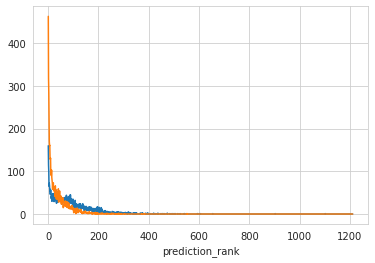

In [47]:
test_df.groupby('score_rank')['is_relevant'].agg(['mean', 'sum']).reset_index().set_index('score_rank')['sum'].plot()
test_df.groupby('prediction_rank')['is_relevant'].agg(['mean', 'sum']).reset_index().set_index('prediction_rank')['sum'].plot()

In [48]:
from catboost.utils import eval_metric

eval_metric(y_test.values, test_df['prediction'].values, 'MAP:top=12', group_id=queries_test.values)

[0.05277794398777704]

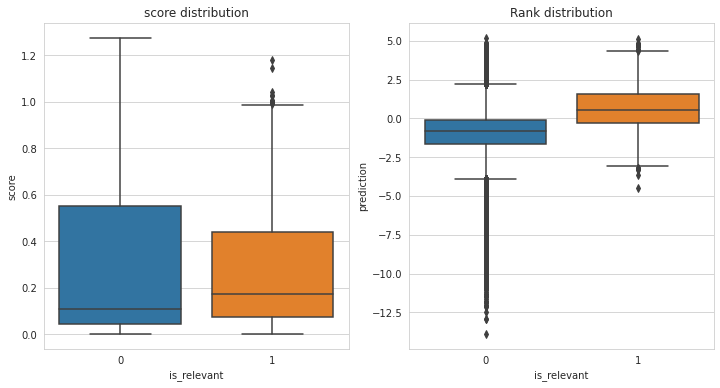

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.boxplot(data=test_df, x='is_relevant', y='score', ax=ax[0])
ax[0].set_title('score distribution')

sns.boxplot(data=test_df, x='is_relevant', y='prediction', ax=ax[1])
plt.title('Rank distribution');

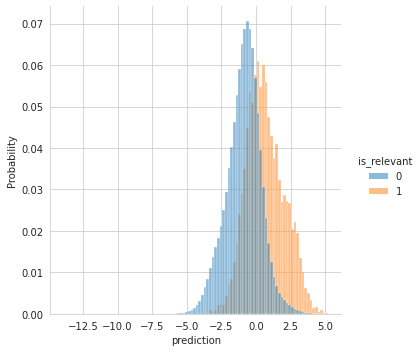

In [50]:
sns.displot(data=test_df, x='prediction', hue='is_relevant', stat='probability', common_norm=False, bins=100)

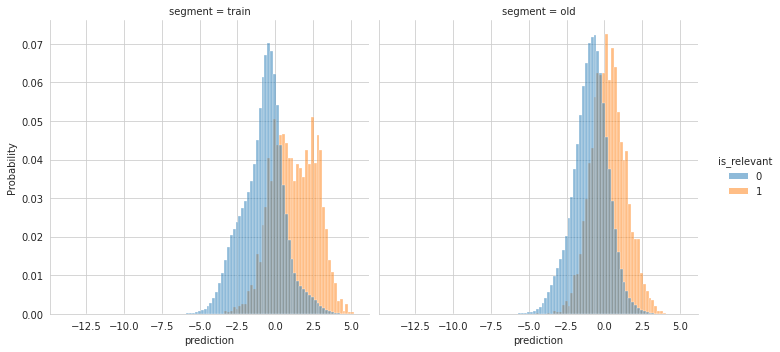

In [51]:
sns.displot(data=test_df, x='prediction', hue='is_relevant', col='segment', stat='probability', common_norm=False, bins=100);

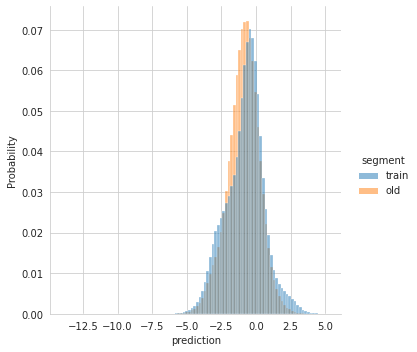

In [52]:
sns.displot(data=test_df, x='prediction', hue='segment', stat='probability', common_norm=False, bins=100);

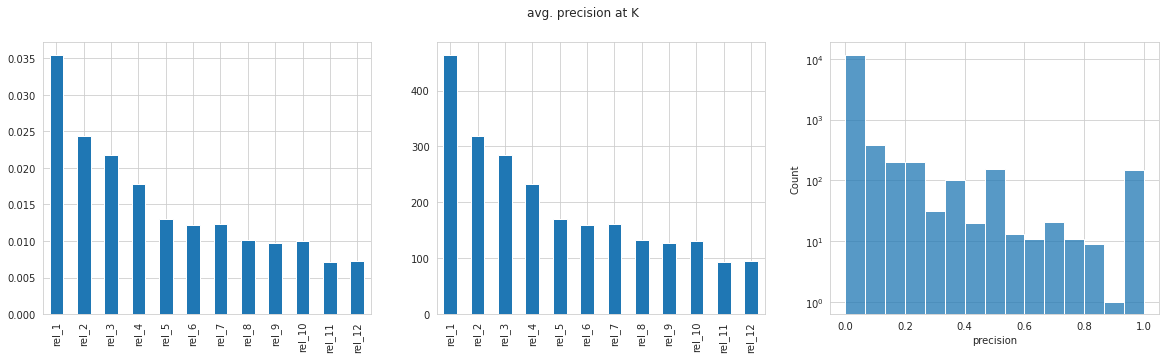

In [53]:
plot_precision_at_k(comb);

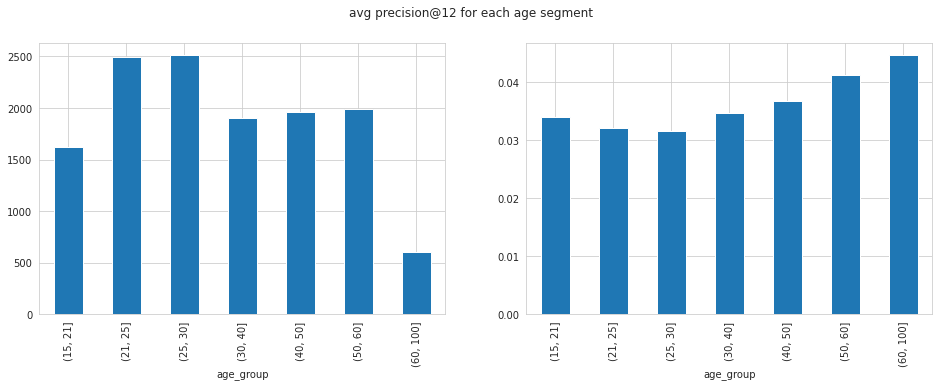

In [54]:
precision_by_age(comb_enriched);

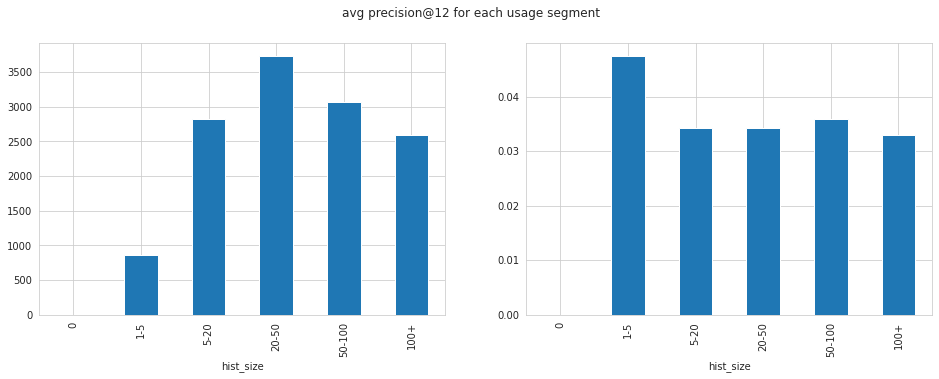

In [55]:
precision_by_usage(comb_enriched);

In [56]:
stats = (
    test_df
    .groupby('customer_id')
    .agg(
        total=('article_id', 'count'),
        hits=('is_relevant', 'sum'),
        has_hit=('is_relevant', 'max')
    ).reset_index()
)

{
    'total_relevance': stats['has_hit'].sum() / stats.shape[0],
    'train_relevance': stats[stats['customer_id'].isin(t_cust)]['has_hit'].sum() / stats.shape[0],
    'old_relevance': stats[stats['customer_id'].isin(old_cust)]['has_hit'].sum() / stats.shape[0],
}

{'total_relevance': 0.29993886596362523,
 'train_relevance': 0.11370930765703806,
 'old_relevance': 0.1862295583065872}

In [57]:
stats = (
    test_df
    .query('score_rank <= 12')
    .groupby('customer_id')
    .agg(
        total=('article_id', 'count'),
        hits=('is_relevant', 'sum'),
        has_hit=('is_relevant', 'max')
    ).reset_index()
)

{
    'total_relevance': stats['has_hit'].sum() / stats.shape[0],
    'train_relevance': stats[stats['customer_id'].isin(t_cust)]['has_hit'].sum() / stats.shape[0],
    'old_relevance': stats[stats['customer_id'].isin(old_cust)]['has_hit'].sum() / stats.shape[0],
}

{'total_relevance': 0.05700748891945591,
 'train_relevance': 0.01543634418462479,
 'old_relevance': 0.04157114473483112}

In [58]:
stats = (
    test_df
    .query('prediction_rank <= 12')
    .groupby('customer_id')
    .agg(
        total=('article_id', 'count'),
        hits=('is_relevant', 'sum'),
        has_hit=('is_relevant', 'max')
    ).reset_index()
)

{
    'total_relevance': stats['has_hit'].sum() / stats.shape[0],
    'train_relevance': stats[stats['customer_id'].isin(t_cust)]['has_hit'].sum() / stats.shape[0],
    'old_relevance': stats[stats['customer_id'].isin(old_cust)]['has_hit'].sum() / stats.shape[0],
}

{'total_relevance': 0.14549900657190892,
 'train_relevance': 0.06663609964847929,
 'old_relevance': 0.07886290692342962}

count    1000.000000
mean        0.035106
std         0.004169
min         0.023357
25%         0.032227
50%         0.034870
75%         0.037839
max         0.050073
dtype: float64


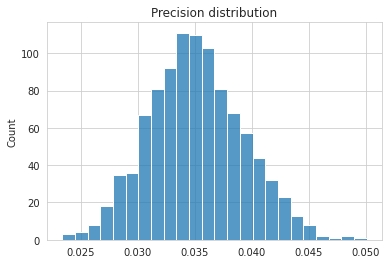

In [59]:
N = 1000
precisions = np.zeros(N)
for i in range(N):
    precisions[i] = comb.sample(n=1000)['precision'].mean()

print(pd.Series(precisions).describe())
sns.histplot(precisions)
plt.title('Precision distribution');

# submission

In [ ]:
model = CatBoostRanker().load_model(fname=str(data_root / 'models' / 'pair_logit.model'))

In [ ]:
submission = pd.read_csv('/data/sstamenov/kaggle-data/sample_submission.csv').drop(columns=['prediction'])
delta = (pd.to_datetime('2020-09-22') - df['t_dat']).dt.days
df['delta_weeks'] = 1 / (1 + np.power(delta // 7, 1))

In [ ]:
submission.head()

In [ ]:
df.head()

In [ ]:
# full_ds = filter_data(df, to_date='2020-09-22')
train = filter_data(df, '2020-09-15', '2020-09-22')

In [ ]:

pipeline = kaggle_hm.als_model.MatrixFactorizationPipeline(min_items=1, min_customers=1, cell_value='time', factors=256, iterations=50, regularization=0.01)
pipeline.fit(train)
rec_df = pipeline.predict(full_ds, N=100)

In [ ]:
rec_df['product_code'] = rec_df['article_id'].str[1:7].astype('int')

In [ ]:
rec_df = calc_features(rec_df, train, c, items)

In [ ]:
old_transactions = filter_data(df, from_date='2020-08-24', to_date='2020-09-22')
item_stats = get_item_stats(old_transactions, '2020-09-22')
rec_df = rec_df.merge(item_stats, on='article_id', how='left')

In [ ]:
rec_df.to_parquet(data_root / 'clean' / 'X_pred.parquet')

In [ ]:
rec_df = pd.read_parquet(data_root / 'clean' / 'X_pred.parquet')

In [ ]:
X_pred = rec_df[features]

In [ ]:
X_pred.head()

In [ ]:
predictions = model.predict(X_pred)
rec_df['prediction'] = predictions
rec_df['rank'] = rec_df.groupby('customer_id')['prediction'].rank(ascending=False, method='first')

relevant_items = rec_df.query('rank <= 12').sort_values(['customer_id', 'rank'], ascending=True)
pred_df = (
    relevant_items.groupby('customer_id', observed=True).agg(candidates=('article_id', list))
)

In [ ]:
pred_df.shape[0]

In [ ]:
submission = submission.merge(c[['customer_id', 'age_group']], on='customer_id', how='left')

In [ ]:
top12_age_pred = age_chart(train)
submission = submission.merge(pred_df, on='customer_id', how='left')
submission = submission.merge(top12_age_pred, on='age_group', how='left').drop(columns=['age_group'])
submission['prediction'] = submission['candidates'].combine_first(submission['naive_pred'])

In [ ]:
submission.head()

In [ ]:
submission.shape[0]

In [ ]:
submission['prediction'] = submission['prediction'].apply(lambda _: ' '.join(_))

In [ ]:
submission.head()

In [ ]:
submission[['customer_id', 'prediction']].to_csv('/data/sstamenov/kaggle-data/output/implicit_time_rank_ftrs_submission.csv', index=False)

In [ ]:
sept = filter_data(df, from_date='2019-09-23', to_date='2019-09-29')

In [ ]:
sept['t_dat'].value_counts().sort_index()

In [ ]:
sept.groupby('t_dat')['customer_id'].nunique().sort_index()

In [ ]:
from kaggle_hm.utils import visualize_items

visualize_items(sept['article_id'].value_counts()[:20].index, rows=4, columns=5)

In [11]:
X_pred.head()

,score,bought,age,product_type_name,colour_group_name,department_name,section_name,garment_group_name,total_cust,item_age,monday_item,avg_per_customer,daily_sales,avg_price,avg_age,median_price,max_price,min_price,bought_same_prod
0,0.378568,1,24.0,Jacket,Greyish Beige,Ladies Sport Woven,Ladies H&M Sport,Unknown,382,0.033333,1,1.197492,13.172414,0.066298,40.954314,0.067780,0.067780,0.027102,1
1,0.280123,0,24.0,Hoodie,Black,Ladies Sport Bras,Ladies H&M Sport,Jersey Fancy,781,0.033333,1,1.199693,26.033333,0.050016,38.413283,0.050831,0.050831,0.031339,0
2,0.195061,0,24.0,Hoodie,Light Pink,Ladies Sport Bras,Ladies H&M Sport,Jersey Fancy,432,0.033333,1,1.119171,14.400000,0.049658,40.621639,0.050831,0.050831,0.037136,0
3,0.184482,0,24.0,Hoodie,Green,Ladies Sport Bras,Ladies H&M Sport,Jersey Fancy,232,0.066667,0,1.094340,15.466667,0.049865,41.327586,0.050831,0.050831,0.038119,0
4,0.168636,0,24.0,Jacket,Pink,Ladies Sport Woven,Ladies H&M Sport,Unknown,77,0.045455,0,1.054795,3.666667,0.065408,45.103896,0.067780,0.067780,0.027119,1


In [12]:
predictions = model.predict(X_pred)
rec_df['prediction'] = predictions
rec_df['rank'] = rec_df.groupby('customer_id')['prediction'].rank(ascending=False, method='first')

relevant_items = rec_df.query('rank <= 12').sort_values(['customer_id', 'rank'], ascending=True)
pred_df = (
    relevant_items.groupby('customer_id', observed=True).agg(candidates=('article_id', list))
)

In [13]:
pred_df.shape[0]

1105000

In [14]:
submission = submission.merge(c[['customer_id', 'age_group']], on='customer_id', how='left')

In [17]:
top12_age_pred = age_chart(train)
submission = submission.merge(pred_df, on='customer_id', how='left')
submission = submission.merge(top12_age_pred, on='age_group', how='left').drop(columns=['age_group'])
submission['prediction'] = submission['candidates'].combine_first(submission['naive_pred'])

In [18]:
submission.head()

,customer_id,candidates,naive_pred,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,"[0568601043, 0779781015, 0568601006, 056859700...","[0751471001, 0923758001, 0924243001, 092424300...","[0568601043, 0779781015, 0568601006, 056859700..."
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,"[0673677002, 0351484039, 0739590027, 077623702...","[0924243001, 0918522001, 0924243002, 091552900...","[0673677002, 0351484039, 0739590027, 077623702..."
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"[0794321007, 0805000001, 0794321008, 080500000...","[0924243001, 0918522001, 0924243002, 091552900...","[0794321007, 0805000001, 0794321008, 080500000..."
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,"[0924243001, 0928206001, 0930380001, 092424300...","[0924243001, 0928206001, 0930380001, 092424300..."
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,"[0896152002, 0896152001, 0730683050, 079158700...","[0924243001, 0928206001, 0930380001, 092424300...","[0896152002, 0896152001, 0730683050, 079158700..."


In [19]:
submission.shape[0]

1371980

In [21]:
submission['prediction'] = submission['prediction'].apply(lambda _: ' '.join(_))

In [22]:
submission.head()

,customer_id,candidates,naive_pred,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,"[0568601043, 0779781015, 0568601006, 056859700...","[0751471001, 0923758001, 0924243001, 092424300...",0568601043 0779781015 0568601006 0568597006 08...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,"[0673677002, 0351484039, 0739590027, 077623702...","[0924243001, 0918522001, 0924243002, 091552900...",0673677002 0351484039 0739590027 0776237020 05...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"[0794321007, 0805000001, 0794321008, 080500000...","[0924243001, 0918522001, 0924243002, 091552900...",0794321007 0805000001 0794321008 0805000007 08...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,"[0924243001, 0928206001, 0930380001, 092424300...",0924243001 0928206001 0930380001 0924243002 09...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,"[0896152002, 0896152001, 0730683050, 079158700...","[0924243001, 0928206001, 0930380001, 092424300...",0896152002 0896152001 0730683050 0791587001 07...


In [23]:
submission[['customer_id', 'prediction']].to_csv('/data/sstamenov/kaggle-data/output/implicit_time_rank_ftrs_submission.csv', index=False)

In [48]:
sept = filter_data(df, from_date='2019-09-23', to_date='2019-09-29')

In [49]:
sept['t_dat'].value_counts().sort_index()

2019-09-23     34076
2019-09-24     36702
2019-09-25     41256
2019-09-26     37128
2019-09-27     35597
2019-09-28    198622
2019-09-29     40043
Name: t_dat, dtype: int64

In [50]:
sept.groupby('t_dat')['customer_id'].nunique().sort_index()

t_dat
2019-09-23     9766
2019-09-24    10975
2019-09-25    12497
2019-09-26    11757
2019-09-27    12208
2019-09-28    42062
2019-09-29    11192
Name: customer_id, dtype: int64

In [ ]:
from kaggle_hm.utils import visualize_items

visualize_items(sept['article_id'].value_counts()[:20].index, rows=4, columns=5)